# SET COVER LAB 1 EXERCISE

In [905]:
import random
from itertools import accumulate
import numpy as np
from matplotlib import pyplot as plt

from icecream import ic

## Used Functions

In [906]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    phenotype = np.logical_or.reduce(SETS[solution])
    return np.all(phenotype)


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

In [907]:
def multiple_mutation_strength(solution: np.ndarray, strenght: float = 0.3) -> np.ndarray:
    mask = rng.random(NUM_SETS) < strenght
    if not np.any(mask):
        mask[np.random.randint(NUM_SETS)] = True
    new_sol = np.logical_xor(solution, mask)
    return new_sol


In [908]:
def fitness(solution: np.ndarray):
    return (valid(solution), -cost(solution))

In [909]:
def count_covered_elements(solution):
    taken_sets = SETS[solution]
    unique_solution = np.logical_xor.reduce(taken_sets, axis=0)
    return unique_solution.sum()

First Instance

In [910]:
UNIVERSE_SIZE = 100
NUM_SETS = 10
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [911]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

ic| fitness(solution): (np.True_, np.float64(-299.2172838738569))
ic| fitness(solution): (np.True_, np.float64(-299.2172838738569))


Number of steps done until the best solution:  0


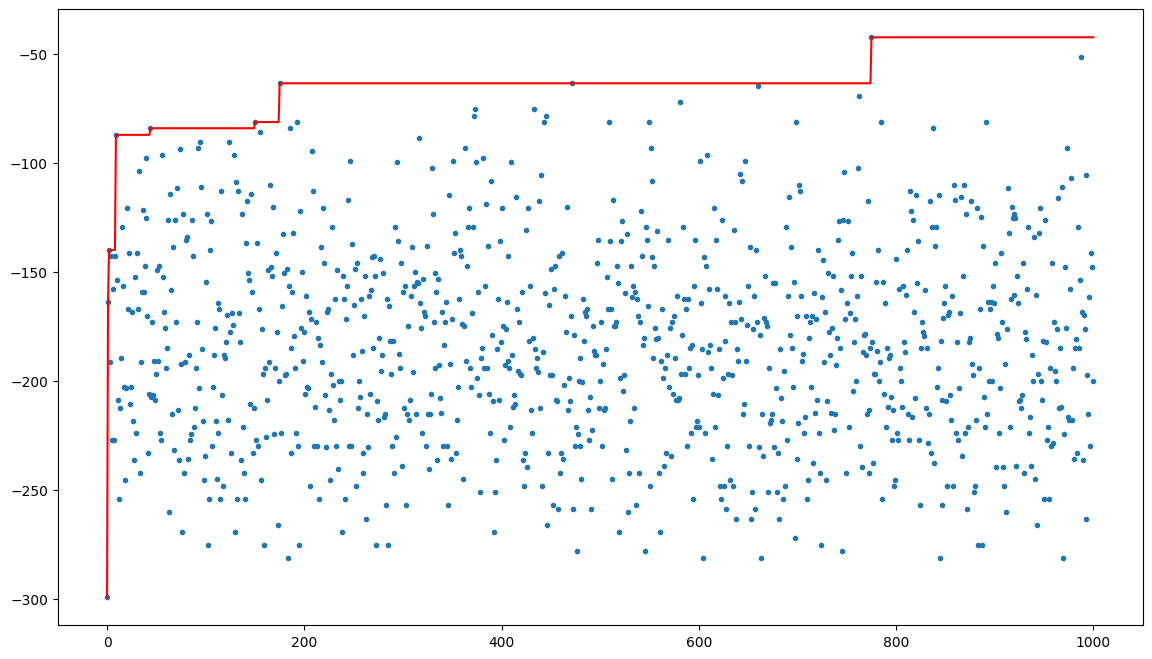

In [912]:
solution = rng.random(NUM_SETS) < 1
sol_fitness = fitness(solution)
history = [float(sol_fitness[1])] #plot of the cost
ic(fitness(solution))
strength = 0.4
number_of_steps = 0

for steps in range(1_000):
    solution_coverage = count_covered_elements(solution)
    new_solution = multiple_mutation_strength(solution, strength)
    new_solution_fitness = fitness(new_solution)
    history.append(float(new_solution_fitness[1]))
    new_solution_coverage = count_covered_elements(new_solution)
            
    if new_solution_fitness > sol_fitness:
        if cost(solution) != cost(new_solution):
            number_of_steps = steps
        solution = new_solution
        sol_fitness = new_solution_fitness
        strength = (abs(new_solution_coverage - solution_coverage) / UNIVERSE_SIZE) 
 
ic(fitness(solution))
print("Number of steps done until the best solution: ", number_of_steps)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

Second Instance

In [928]:
UNIVERSE_SIZE = 1000
NUM_SETS = 100
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [929]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

ic| fitness(solution): (np.True_, np.float64(-33681.219564814324))
ic| fitness(solution): (np.True_, np.float64(-6676.8330951315065))


Number of steps done until the best solution:  245


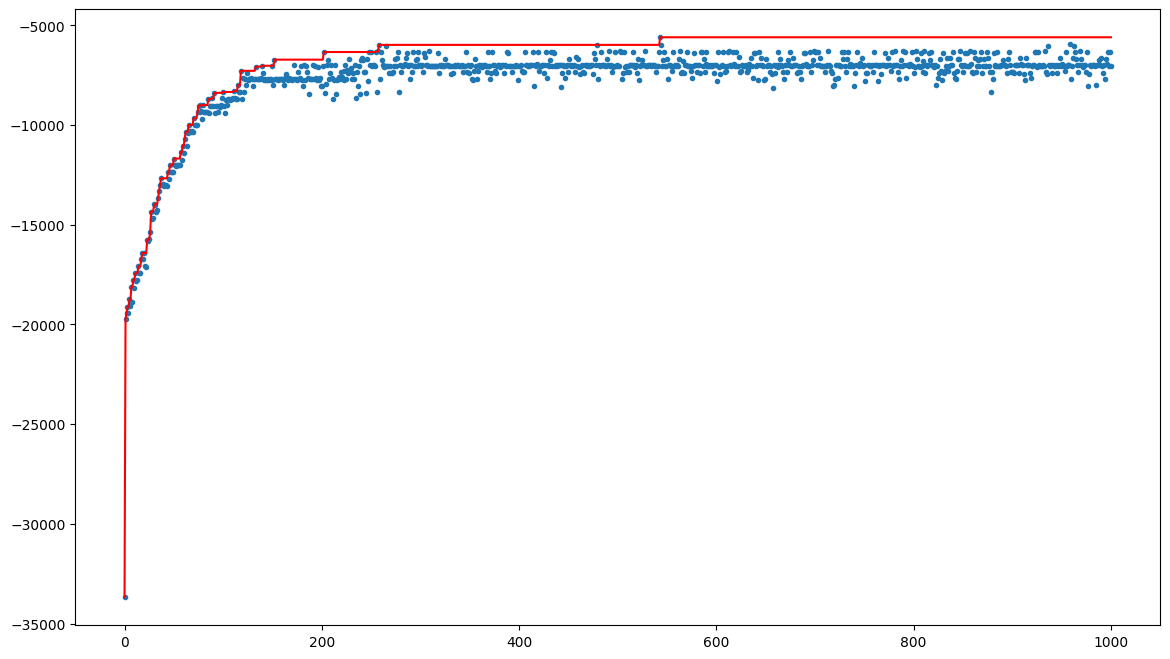

In [940]:
solution = rng.random(NUM_SETS) < 1
sol_fitness = fitness(solution)
history = [float(sol_fitness[1])] #plot of the cost
ic(fitness(solution))
strength = 0.4
number_of_steps = 0

for steps in range(1_000):
    solution_coverage = count_covered_elements(solution)
    new_solution = multiple_mutation_strength(solution, strength)
    new_solution_fitness = fitness(new_solution)
    history.append(float(new_solution_fitness[1]))
    new_solution_coverage = count_covered_elements(new_solution)
            
    if new_solution_fitness > sol_fitness:
        if cost(solution) != cost(new_solution):
            number_of_steps = steps
        solution = new_solution
        sol_fitness = new_solution_fitness
        strength = (abs(new_solution_coverage - solution_coverage) / UNIVERSE_SIZE)
 
ic(fitness(solution))
print("Number of steps done until the best solution: ", number_of_steps)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

Third Instance

In [916]:
UNIVERSE_SIZE = 10000
NUM_SETS = 1000
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [917]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

ic| fitness(solution): (np.True_, np.float64(-4278005.9373428505))
ic| fitness(solution): (np.True_, np.float64(-1067003.193690525))


Number of steps done until the best solution:  895


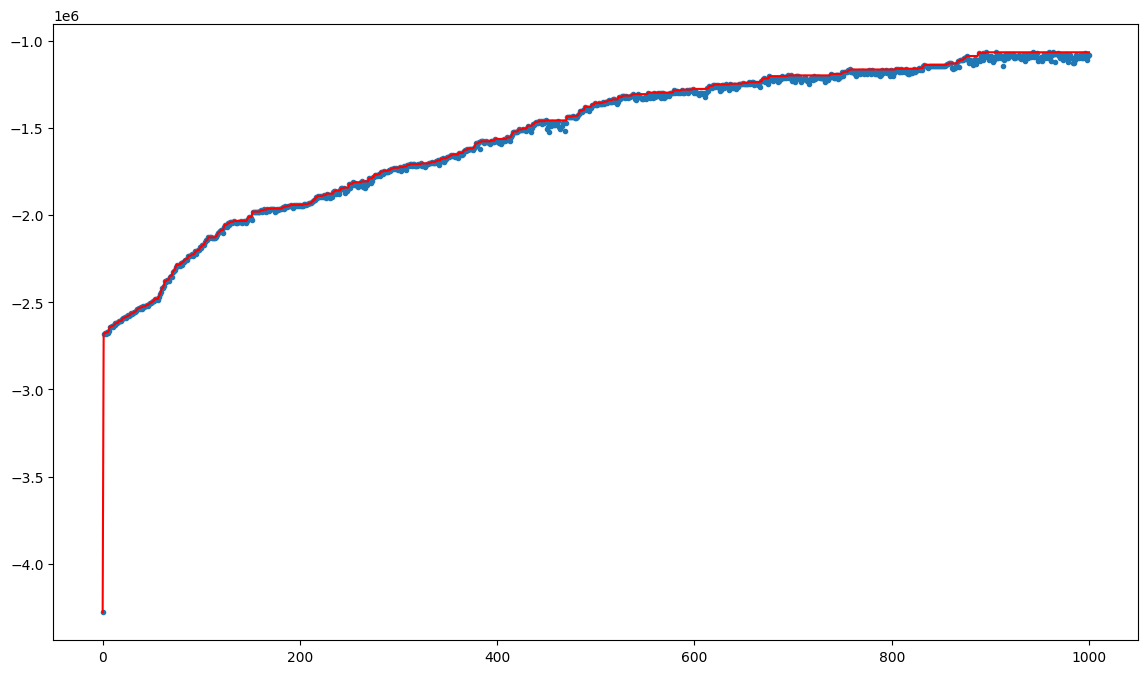

In [918]:
solution = rng.random(NUM_SETS) < 1
sol_fitness = fitness(solution)
history = [float(sol_fitness[1])] #plot of the cost
ic(fitness(solution))
strength = 0.4
number_of_steps = 0

for steps in range(1_000):
    solution_coverage = count_covered_elements(solution)
    new_solution = multiple_mutation_strength(solution, strength)
    new_solution_fitness = fitness(new_solution)
    history.append(float(new_solution_fitness[1]))
    new_solution_coverage = count_covered_elements(new_solution)
            
    if new_solution_fitness > sol_fitness:
        if cost(solution) != cost(new_solution):
            number_of_steps = steps
        solution = new_solution
        sol_fitness = new_solution_fitness
        strength = (abs(new_solution_coverage - solution_coverage) / UNIVERSE_SIZE)
 
ic(fitness(solution))
print("Number of steps done until the best solution: ", number_of_steps)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

Fourth Instance

In [919]:
UNIVERSE_SIZE = 100000
NUM_SETS = 10000
DENSITY = 0.1

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [920]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

ic| fitness(solution): (np.True_, np.float64(-251188366.85957783))
ic| fitness(solution): (np.True_, np.float64(-111161441.07666963))


Number of steps done until the best solution:  996


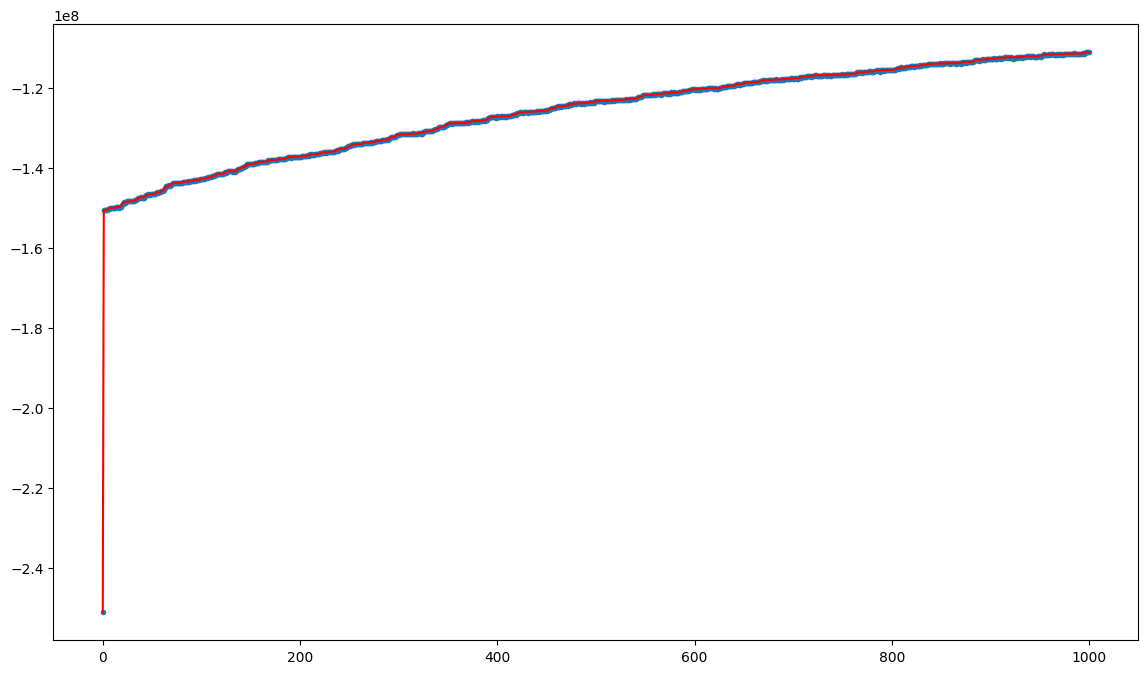

In [921]:
solution = rng.random(NUM_SETS) < 1
sol_fitness = fitness(solution)
history = [float(sol_fitness[1])] #plot of the cost
ic(fitness(solution))
strength = 0.4
number_of_steps = 0

for steps in range(1_000):
    solution_coverage = count_covered_elements(solution)
    new_solution = multiple_mutation_strength(solution, strength)
    new_solution_fitness = fitness(new_solution)
    history.append(float(new_solution_fitness[1]))
    new_solution_coverage = count_covered_elements(new_solution)
            
    if new_solution_fitness > sol_fitness:
        if cost(solution) != cost(new_solution):
            number_of_steps = steps
        solution = new_solution
        sol_fitness = new_solution_fitness
        strength = (abs(new_solution_coverage - solution_coverage) / UNIVERSE_SIZE)
 
ic(fitness(solution))
print("Number of steps done until the best solution: ", number_of_steps)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

Fifth Instance

In [922]:
UNIVERSE_SIZE = 100000
NUM_SETS = 10000
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [923]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

ic| fitness(solution): (np.True_, np.float64(-538431881.3458014))
ic| fitness(solution): (np.True_, np.float64(-237973831.27871063))


Number of steps done until the best solution:  992


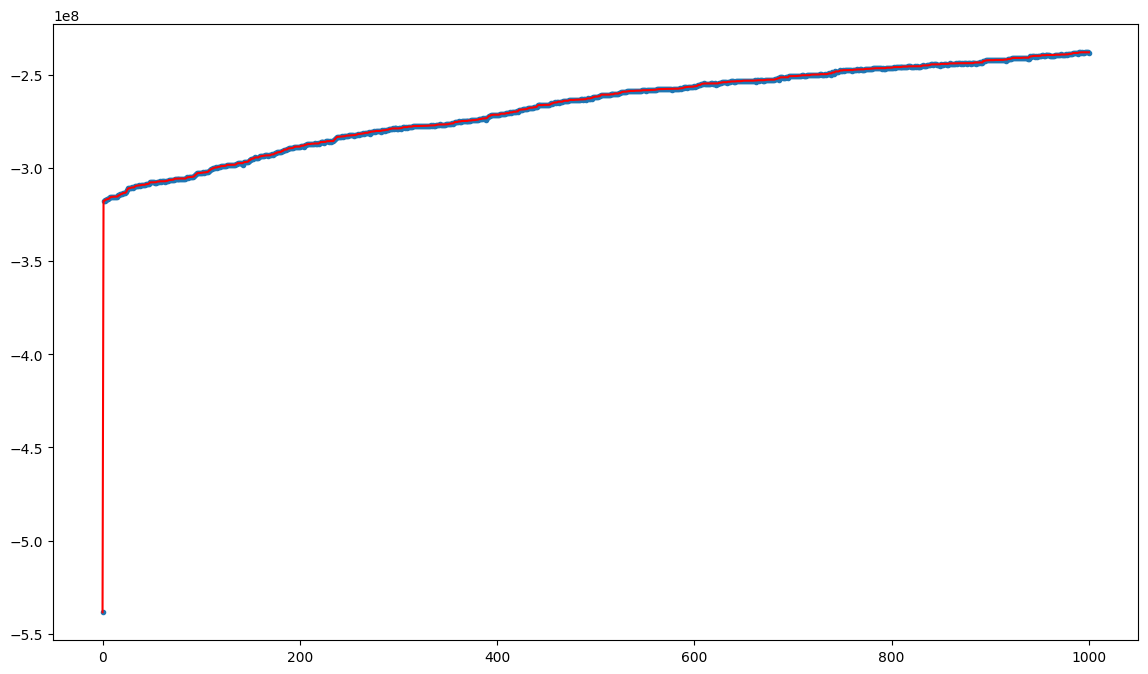

In [924]:
solution = rng.random(NUM_SETS) < 1
sol_fitness = fitness(solution)
history = [float(sol_fitness[1])] #plot of the cost
ic(fitness(solution))
strength = 0.4
number_of_steps = 0

for steps in range(1_000):
    solution_coverage = count_covered_elements(solution)
    new_solution = multiple_mutation_strength(solution, strength)
    new_solution_fitness = fitness(new_solution)
    history.append(float(new_solution_fitness[1]))
    new_solution_coverage = count_covered_elements(new_solution)
            
    if new_solution_fitness > sol_fitness:
        if cost(solution) != cost(new_solution):
            number_of_steps = steps
        solution = new_solution
        sol_fitness = new_solution_fitness
        strength = (abs(new_solution_coverage - solution_coverage) / UNIVERSE_SIZE)
 
ic(fitness(solution))
print("Number of steps done until the best solution: ", number_of_steps)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

Sixth Instance

In [925]:
UNIVERSE_SIZE = 100000
NUM_SETS = 10000
DENSITY = 0.3

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [926]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

ic| fitness(solution): (np.True_, np.float64(-841110512.4982741))
ic| fitness(solution): (np.True_, np.float64(-369131824.6461967))


Number of steps done until the best solution:  999


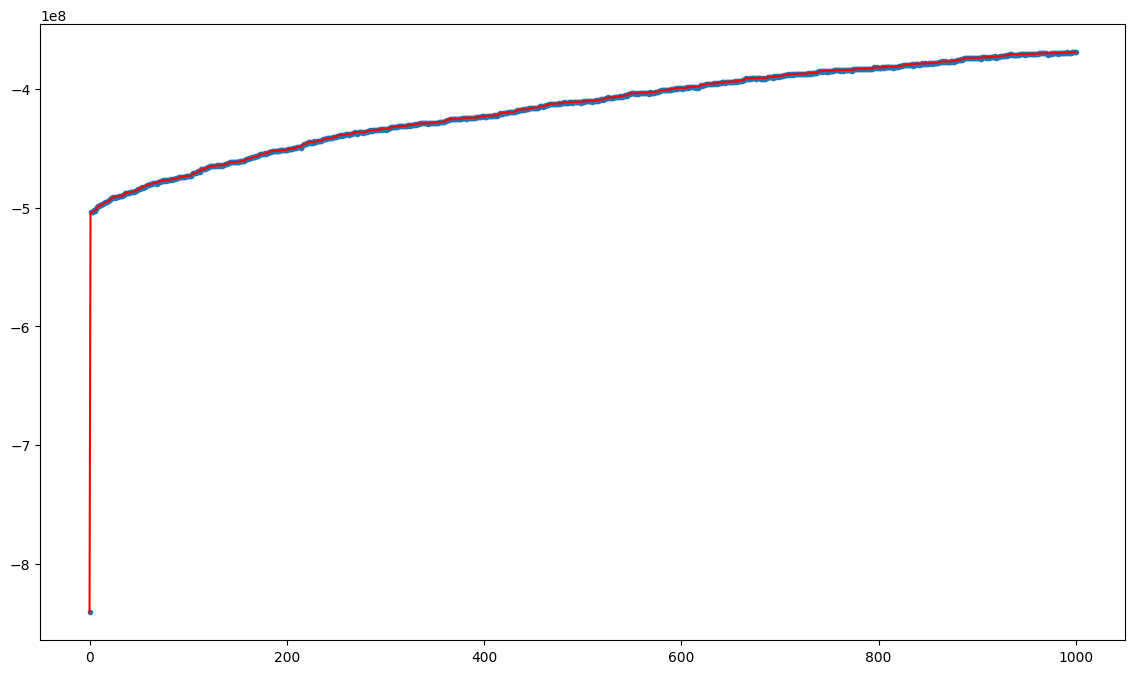

In [927]:
solution = rng.random(NUM_SETS) < 1
sol_fitness = fitness(solution)
history = [float(sol_fitness[1])] #plot of the cost
ic(fitness(solution))
strength = 0.4
number_of_steps = 0

for steps in range(1_000):
    solution_coverage = count_covered_elements(solution)
    new_solution = multiple_mutation_strength(solution, strength)
    new_solution_fitness = fitness(new_solution)
    history.append(float(new_solution_fitness[1]))
    new_solution_coverage = count_covered_elements(new_solution)
            
    if new_solution_fitness > sol_fitness:
        if cost(solution) != cost(new_solution):
            number_of_steps = steps
        solution = new_solution
        sol_fitness = new_solution_fitness
        strength = (abs(new_solution_coverage - solution_coverage) / UNIVERSE_SIZE)
 
ic(fitness(solution))
print("Number of steps done until the best solution: ", number_of_steps)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")